<hr>

In [8]:
# Set whether to save figures
save_figs = False

# Set directory
dir_name = "plots"

In [9]:
# Set  name of trial
trial_name = "lowcis_expbeta"

# Random seed
seed = 2021

__Set growth min and max__

In [10]:
# Set min and max density
rho_min, rho_max = 1, 5.63040245

__Set RHS of dynamical equation__

In [11]:
# Set the RHS function in long-form
rhs_long = tc_rhs_beta_g_normA
rhs_long_inhib = tc_rhs_beta_g_normA_inhib

# Set beta(rho)
beta_func = lsig.beta_rho_exp
beta_args = (0.35,)   # parameter `m` for beta(rho)

__Set parameters for DDE integration__

In [12]:
# # Set DDE parameters
# alpha = 3
# k = 0.03
# p = 2
# delta = 1
# lambda_ = 1e-3
# g = 1

# # Set delay
# delay = 0.3

# # Package params
# param_names = ["alpha", "k", "p", "delta", "lambda_", "g"]
# param_vals = alpha, k, p, delta, lambda_, g

# # Package arguments for lsig.integrate_DDE and 
# #   lsig.integrate_DDE_varargs. Density param is 
# #   initialized with rho_min.
# dde_args = *param_vals, delay, rho_min

__Set max interaction radius__

In [13]:
# cell-cell distance (dimensionless)
r = 1.   

# maximum interaction radius in cell-lengths 
irad = 3 * r + 0.05

<hr>

## Fetch parameters

In [14]:
# Read trial parameters from CSV
params_df = pd.read_csv("parameters_" + trial_name + ".csv")
params_df

,trial_name,parameter,value
0,lowcis_expbeta,alpha,3.00000
1,lowcis_expbeta,k,0.03000
2,lowcis_expbeta,p,2.00000
3,lowcis_expbeta,delta,1.00000
4,lowcis_expbeta,lambda_,0.00001
5,lowcis_expbeta,g,1.00000
6,lowcis_expbeta,beta_param_0,1.00000
7,lowcis_expbeta,delay,0.30000


In [15]:
# Get any arguments for beta function
is_beta_arg = [p.startswith("beta_") for p in params_df["parameter"].values]
beta_args   = params_df.value.values[is_beta_arg]

# Get the delay parameter
is_delay    = [p == "delay" for p in params_df["parameter"].values]
delay       = params_df.value.values[is_delay][0]

# Package all other parameters 
is_param    = [not (ba or d) for ba, d in zip(is_beta_arg, is_delay)]
param_names = params_df.parameter.values[is_param]
param_vals  = params_df.value.values[is_param]

# Package arguments for lsig.integrate_DDE and 
#   lsig.integrate_DDE_varargs. Density param is 
#   initialized with rho_min.
dde_args = *param_vals, rho_min

In [16]:
# Get index of `rho`
where_rho = len(dde_args) - 1

# Get `k`
where_k = next(i for i, pn in enumerate(param_names) if "k" == pn)
k = param_vals[where_k]
thresh = k

# Get `g`
where_g = next(i for i, pn in enumerate(param_names) if "g" == pn)
g = param_vals[where_g]

<hr>

## To add:
- fit m
- fit time-scale + convert all time to days

In [17]:
t_to_days = lambda t: t / 7.28398176e-01   # time in days, based on growth rate of untreated strain

<hr>

### Scan growth parameters

__Set figure parameters__

In [18]:
# Define free parameters for parameter scan
g_space = np.logspace(np.log10(1/3), np.log10(3), 5)
rho_max_space = np.linspace(1, 6, 6)
free_params = (g_space, rho_max_space)

# Generate parameter-sets
param_space = np.meshgrid(*free_params)
param_space = np.array(param_space).T.reshape(-1, len(free_params))
n_runs = param_space.shape[0]

In [18]:
rho_0 = 1

pct_s = 1

ks = 3

__Set time parameters__

In [19]:
# Set time parameters
tmax = 5
nt_t = 100
nt = int(nt_t * tmax) + 1
t = np.linspace(0, tmax, nt)

__Construct lattice of cells__

In [20]:
# Make lattice and get adjacency matrix
rows = cols = 100
X = lsig.hex_grid(rows, cols, r=r)

# Get # cells
n = X.shape[0]

__Get cell adjacency__

In [21]:
# Calculate cell adjacency
kAdj_1 = k_step_Adj(1, rows, cols, row_stoch=True)
kAdj_3 = k_step_Adj(3, rows, cols, row_stoch=True)

__Set sender cell location__

In [35]:
# Set seed
np.random.seed(seed)

# Specify percent of population that is sender
n_s = int(n * (pct_s/100)) + 1

# Assign senders randomly
sender_idx = np.random.choice(n, n_s, replace=False)

__Get RHS of signaling DDE__

In [37]:
# Get RHS of DDE equation to pass to integrator
rhs_1 = lsig.get_DDE_rhs(rhs_long, kAdj_1, sender_idx, beta_func, beta_args,)
rhs_3 = lsig.get_DDE_rhs(rhs_long, kAdj_3, sender_idx, beta_func, beta_args,)

In [38]:
# Get initial conditions
S0 = np.zeros(n)
S0[sender_idx] = 1

In [39]:
###################
##  FOR TESTING  ##
###################

new_args = (
    3.0,    # alpha
    0.03,   # k
    2.0,    # p
    1.0,    # delta
    1e-5,   # lambda
    1.0,    # g
    1       # rho (can be variable)
)

In [40]:
# Make mutable copy of args
args = list(dde_args)

# Initialize results vectors
rho_param_t = np.empty((n_runs, nt), dtype=np.float32)
X_param_t = np.empty((n_runs, nt, n, 2), dtype=np.float32)
S_param_t = np.empty((n_runs, nt, n), dtype=np.float32)

# Make iterator
iterator = range(n_runs)
iterator = tqdm(iterator)

for i in iterator:
    
    # Get RHS function (different adjacencies)
#     rhs = (rhs_3, rhs_1, rhs_1)[i]
    rhs = rhs_3
    
    # Get parameters
    g_, rho_max_ = param_space[i]
    
    # Calculate density and contact length
    rho_t = lsig.logistic(t, g_, 1., rho_max_)
    r_t = 1/np.sqrt(rho_t)

    # Get cell positions
    X_t = np.empty((nt, n, 2))
    X_t[:, :, 0] = np.outer(r_t, X[:, 0])
    X_t[:, :, 1] = np.outer(r_t, X[:, 1])
    
    args[where_g] = g_
    
    # Simulate
    S_t = lsig.integrate_DDE_varargs(
        t,
        rhs,
        var_vals=rho_t,
        where_vars=where_rho,
        dde_args=args,
        E0=S0,
        delay=delay
    )
    
    # Save results
    rho_param_t[i] = rho_t
    X_param_t[i] = X_t
    S_param_t[i] = S_t

100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


In [41]:
# Get activated cells
S_act_t = S_param_t > k
S_act_num = S_act_t.sum(axis=2)

# Activated area
A_act_param = np.array([lsig.A_cells_um(S_act_num[i], rho_param_t[i]) for i in range(n_runs)])

# Mean fluorescence
S_mean_t = S_param_t.mean(axis=2)

# Percent of cells activated
S_prop_t = S_act_t.mean(axis=2)

:Overlay
   .Curve.I   :Curve   [x]   (y)
   .Curve.II  :Curve   [x]   (y)
   .Curve.III :Curve   [x]   (y)
   .Curve.IV  :Curve   [x]   (y)
   .Curve.V   :Curve   [x]   (y)
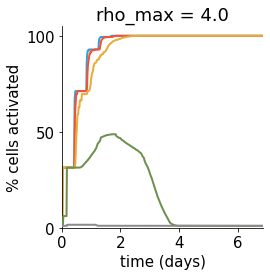

In [42]:
%%capture --no-display

g_idx = 3

where_g_idx = np.arange(g_idx, n_runs, rho_max_space.size)
print(param_space[where_g_idx])

param_curves = hv.Overlay(
    [
        hv.Curve(
            data = (t_to_days(t), S_prop_t[i] * 100),
#             label = f"{param_space[i, 1]:.1f}",
        ).opts(
            xlabel = r"time (days)",
            xlim = (0, None),
            ylabel = r"% cells activated",
            ylim = (0, 105),
            yticks = (0, 50, 100),
            fontscale=1.5,
            title=f"rho_max = {param_space[where_g_idx[0], 1]:.1f}",
        )
        for i in where_g_idx
    ]
).opts(
    legend_position="right"
)

param_curves

In [43]:
print(param_space[where_g_idx])

[[0.33333333 4.        ]
 [0.57735027 4.        ]
 [1.         4.        ]
 [1.73205081 4.        ]
 [3.         4.        ]]


:Overlay
   .Curve.A_1_full_stop_0 :Curve   [x]   (y)
   .Curve.A_2_full_stop_0 :Curve   [x]   (y)
   .Curve.A_3_full_stop_0 :Curve   [x]   (y)
   .Curve.A_4_full_stop_0 :Curve   [x]   (y)
   .Curve.A_5_full_stop_0 :Curve   [x]   (y)
   .Curve.A_6_full_stop_0 :Curve   [x]   (y)
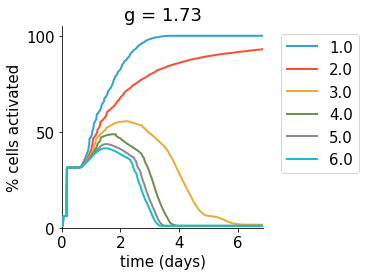

In [44]:
%%capture --no-display

rm_idx = 3

where_rm_idx = np.arange(rho_max_space.size * rm_idx, rho_max_space.size * (rm_idx + 1))

param_curves = hv.Overlay(
    [
        hv.Curve(
            data = (t_to_days(t), S_prop_t[i] * 100),
            label = f"{param_space[i, 1]:.1f}",
        ).opts(
            xlabel = r"time (days)",
            xlim = (0, None),
            ylabel = r"% cells activated",
            ylim = (0, 105),
            yticks = (0, 50, 100),
            zlabel=r"$\rho_{max}$",
            fontscale=1.5,
            title=f"g = {param_space[where_rm_idx[0], 0]:.2f}",
        )
        for i in where_rm_idx
    ]
).opts(
    legend_position="right",
)

param_curves

In [45]:
param_space[where_rm_idx]

array([[1.73205081, 1.        ],
       [1.73205081, 2.        ],
       [1.73205081, 3.        ],
       [1.73205081, 4.        ],
       [1.73205081, 5.        ],
       [1.73205081, 6.        ]])

<hr>

### Save plots and videos

In [46]:
# Make list of drug names for filename
drug_names = ["untreated", "FGF2", "ROCKi"]

In [47]:
# %%capture --no-display

# # if True:
# if save_figs:
    
#     # Set plot filepath and format
#     fmt = "png"
#     plot1_name = trial_name + "_drug_conditions_plot_irad_{0:.1f}_ks_{1}".format(
#         irad, ks
#     ) + "." + fmt
#     plot1_path = os.path.join(dir_name, plot1_name)

#     hv.save(plot_drugs1, plot1_path, fmt=fmt, dpi=150)
    
#     plot1nl_name = trial_name + "_drug_conditions_plot_nolegend_irad_{0:.1f}_ks_{1}".format(
#         irad, ks
#     ) + "." + fmt
#     plot1nl_path = os.path.join(dir_name, plot1nl_name)

#     hv.save(plot_drugs1_nolegend, plot1nl_path, fmt=fmt, dpi=150)
    

In [48]:
# if save_figs:
#     for drug in range(3):
        
#         vid_name = trial_name + "_{0}_vid_irad_{1:.1f}_ks{2}".format(
#             drug_names[drug], irad, ks
#         )
        
#         # Function for plot title
#         title_fun = lambda i: f"Time = {t[i]:.2f}, " + r"$\rho$" + f" = {rho_drug_t[drug, i]:.2f}"

#         lsig.animate_colormesh(
#             X_arr=X_drug_t[drug],
#             rows=rows,
#             cols=cols,
#             var_t=S_drug_t[drug],
# #             n_interp=51,
#             n_frames=75,
#             file_name=vid_name,
#             dir_name=dir_name,
#             fps=15, 
#             vmin=0, 
#             vmax=1, 
#             cmap="kgy",
#             title_fun=title_fun,
#             axis_off=True,
#         #     xlim=xlim_,
#         #     ylim=ylim_,
#         )

<hr>

## Figure parameters

In [162]:
rho_0 = 1

pct_s = 1

ks = 3

__Set time parameters__

In [163]:
# Set time parameters
tmax = 5
nt_t = 100
nt = int(nt_t * tmax) + 1
t = np.linspace(0, tmax, nt)

__Construct lattice of cells__

In [164]:
# Make lattice and get adjacency matrix
rows = cols = 80
X = lsig.hex_grid(rows, cols, r=r)

# Get # cells
n = X.shape[0]

__Get cell adjacency__

In [165]:
# Calculate cell adjacency
kAdj_1 = k_step_Adj(1, rows, cols, row_stoch=True)
kAdj_3 = k_step_Adj(3, rows, cols, row_stoch=True)

__Set sender cell location__

In [166]:
# Set seed
np.random.seed(seed)

# Specify percent of population that is sender
n_s = int(n * (pct_s/100)) + 1

# Assign senders randomly
sender_idx = np.random.choice(n, n_s, replace=False)

In [169]:
sender_idx

array([ 395, 2220, 1511, 4232, 5736, 1279, 4710, 4249, 3583, 2912, 3018,
       4965, 2491, 4445, 1201, 1034, 4578, 2471, 1714, 2738,  534,  953,
       5598, 1853,  854, 3357, 5629, 5203, 3042, 4472,   28, 4756, 3402,
       6028, 4454, 1020,  735, 5184,   38, 3309,  461, 3658, 5955, 3191,
       5364,  789, 2965,  285, 1518, 3230,  645, 5857, 4175, 3373, 2502,
       4798, 3823, 2325, 3569, 1288, 4936,  494, 3543, 2159, 5192])

__Get RHS of signaling DDE__

In [167]:
# Get RHS of DDE equation to pass to integrator
rhs_1 = lsig.get_DDE_rhs(rhs_long, kAdj_1, sender_idx, beta_func, beta_args,)
rhs_3 = lsig.get_DDE_rhs(rhs_long, kAdj_3, sender_idx, beta_func, beta_args,)

In [168]:
# Get initial conditions
S0 = np.zeros(n)
S0[sender_idx] = 1

<hr>

## Parameter sweeps

In [174]:
# Define free parameters for parameter scan
g_space = np.logspace(-1, 1, 25)
rho_max_space = np.linspace(0, 6, 25)[1:]
free_params = (g_space, rho_max_space)

# Generate parameter-sets
param_space = np.meshgrid(*free_params)
param_space = np.array(param_space).T.reshape(-1, len(free_params))
n_runs = param_space.shape[0]

In [175]:
# Make mutable copy of dde args
args = list(dde_args)

# Initialize results vectors
S_actnum_param = np.empty((n_runs, nt), dtype=np.float32)
S_mean_param = np.empty((n_runs, nt), dtype=np.float32)

# Make iterator
iterator = range(n_runs)
iterator = tqdm(iterator)

for i in iterator:
    
    # Get RHS function (different adjacencies)
#     rhs = (rhs_3, rhs_1, rhs_1)[i]
    rhs = rhs_1
    
    # Get parameters
    g_, rho_max_ = param_space[i]
    args[where_g] = g_
    
    # Calculate density
    rho_t = lsig.logistic(t, g_, 1., rho_max_)

    # Simulate
    S_t = lsig.integrate_DDE_varargs(
        t,
        rhs,
        var_vals=rho_t,
        where_vars=where_rho,
        dde_args=args,
        E0=S0,
        delay=delay
    )
    
    # Get activated cells
    S_act_t = S_t > k
    S_actnum_t = S_act_t.sum(axis=1)

    # Mean fluorescence
    S_mean_t = S_t.mean(axis=1)
    
    # Save results
    S_actnum_param[i] = S_actnum_t
    S_mean_param[i] = S_mean_t

100%|██████████| 600/600 [01:10<00:00,  8.53it/s]


<hr>

## Sampling around the phase boundary

I want a greater resolution around this line, so I will sample densely around it.

In [233]:
n_samples = 500
sd = 0.5

log_g_samples = st.uniform.rvs(-1, 1.5, n_samples)
rho_sample_means = crit_rho_approx(10 ** log_g_samples)
rho_samples = st.norm.rvs(loc=rho_sample_means, scale = sd)

neg_rho_samples = (rho_samples < 0).nonzero()[0]

In [206]:
# Resample negative values
maxiter = 100
for i in neg_rho_samples:
    
    k = 0
    rho_is_neg = True
    
    while (k < maxiter) & (rho_is_neg):
        log_g_samples[i] = st.uniform.rvs(-1, 1.5)
        rho_sample_means[i] = crit_rho_approx(10 ** log_g_samples[i])
        rho_samples[i] = st.norm.rvs(loc=rho_sample_means[i], scale = sd)
        
        rho_is_neg = rho_samples[i] < 0
        k += 1
        
    if rho_is_neg:
        print("maxiter reached")

In [207]:
sample_params = np.array([10 ** log_g_samples, rho_samples]).T

In [211]:
# Make mutable copy of dde args
args = list(dde_args)

# Initialize results vectors
S_actnum_param = np.empty((n_samples, nt), dtype=np.float32)
S_mean_param = np.empty((n_samples, nt), dtype=np.float32)

# Make iterator
iterator = range(sample_params.shape[0])
iterator = tqdm(iterator)

for i in iterator:
    
    # Get RHS function (different adjacencies)
#     rhs = (rhs_3, rhs_1, rhs_1)[i]
    rhs = rhs_1
    
    # Get parameters
    g_, rho_ = sample_params[i]
    
    # Assign params
    args[where_g] = g_
    args[where_rho] = rho_
    
    # Simulate
    S_t = lsig.integrate_DDE(
        t,
        rhs,
#         var_vals=rho_t,
#         where_vars=where_rho,
        dde_args=args,
        E0=S0,
        delay=delay
    )
    
    # Get activated cells
    S_act_t = S_t > k
    S_actnum_t = S_act_t.sum(axis=1)

    # Mean fluorescence
    S_mean_t = S_t.mean(axis=1)
    
    # Save results
    S_actnum_param[i] = S_actnum_t
    S_mean_param[i] = S_mean_t

100%|██████████| 500/500 [00:54<00:00,  9.14it/s]


In [212]:
# Percent of cells activated
S_prop_param = S_actnum_param / n

In [213]:
monotonicity = np.array([is_monotonic(s) for s in S_prop_param])

biphasic = np.array([is_biphasic(s, 0.2) for s in S_prop_param])

propagation_bool = np.array([is_propagated(s, 0.2) for s in S_prop_param])

# phase_behavior = (monotonicity.astype(int) + propagation_bool.astype(int)) * propagation_bool

phase_behavior = ((~biphasic).astype(int) + propagation_bool.astype(int)) * propagation_bool

:Overlay
   .Scatter.I :Scatter   [x]   (y)
   .HLine.I   :HLine   [x,y]
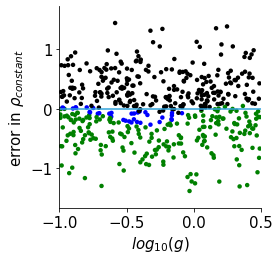

In [221]:
plot = hv.Scatter(
    (log_g_samples, rho_samples - rho_sample_means)
).opts(
#         logx=True, 
    xlabel = r"$log_{10} (g)$",
#     xticks = 3,
    ylabel = r"error in $\rho_{constant}$",
#     yticks = (2, 4, 6, 8, 10),
#         marker = "s",
    s=20,
    c=np.array(["k", "b", "g"])[phase_behavior], 
    aspect=1,
    xlim=(-1, 0.5),
#     ylim=(1, 10),
    fontscale=1.5,
#     title= f"Constant density"
) * hv.HLine(0)

plot

<hr>

## Scanning growth parameter space for activation behavior

__Set figure parameters__

In [222]:
# Define free parameters for parameter scan
g_space = np.logspace(-1, 1, 17)
rho_0_space = np.linspace(0, 10, 16)[1:]
rho_max_space = np.linspace(1, 6, 6)
free_params = (g_space, rho_0_space, rho_max_space)

# Generate parameter-sets
param_space = np.meshgrid(*free_params)
param_space = np.array(param_space).T.reshape(-1, len(free_params))
n_runs = param_space.shape[0]

In [223]:
# Make mutable copy of dde args
args = list(dde_args)

# Initialize results vectors
S_actnum_param = np.empty((n_runs, nt), dtype=np.float32)
S_mean_param = np.empty((n_runs, nt), dtype=np.float32)

# Make iterator
iterator = range(n_runs)
iterator = tqdm(iterator)

for i in iterator:
    
    # Get RHS function (different adjacencies)
#     rhs = (rhs_3, rhs_1, rhs_1)[i]
    rhs = rhs_1
    
    # Get parameters
    g_, rho_0_, rho_max_ = param_space[i]
    
    # Calculate density and contact length
    rho_t = lsig.logistic(t, g_, rho_0_, rho_max_)
    r_t = 1/np.sqrt(rho_t)

    args[where_g] = g_
    
    # Simulate
    S_t = lsig.integrate_DDE_varargs(
        t,
        rhs,
        var_vals=rho_t,
        where_vars=where_rho,
        dde_args=args,
        E0=S0,
        delay=delay
    )
    
    # Get activated cells
    S_act_t = S_t > k
    S_actnum_t = S_act_t.sum(axis=1)

    # Mean fluorescence
    S_mean_t = S_t.mean(axis=1)
    
    # Save results
    S_actnum_param[i] = S_actnum_t
    S_mean_param[i] = S_mean_t

100%|██████████| 1530/1530 [02:42<00:00,  9.39it/s]


In [225]:
# Percent of cells activated
S_prop_param = S_actnum_param / n

In [226]:
# monotonicity = np.array([is_monotonic(s) for s in S_prop_param])

biphasic = np.array([is_biphasic(s, 0.2) for s in S_prop_param])

propagation_bool = np.array([is_propagated(s, 0.2) for s in S_prop_param])

# phase_behavior = (monotonicity.astype(int) + propagation_bool.astype(int)) * propagation_bool

phase_behavior = ((~biphasic).astype(int) + propagation_bool.astype(int)) * propagation_bool

:Layout
   .Overlay.I   :Overlay
      .Image.I :Image   [x,y]   (z)
      .Curve.I :Curve   [x]   (y)
   .Overlay.II  :Overlay
      .Image.I :Image   [x,y]   (z)
      .Curve.I :Curve   [x]   (y)
   .Overlay.III :Overlay
      .Image.I :Image   [x,y]   (z)
      .Curve.I :Curve   [x]   (y)
   .Overlay.IV  :Overlay
      .Image.I :Image   [x,y]   (z)
      .Curve.I :Curve   [x]   (y)
   .Overlay.V   :Overlay
      .Image.I :Image   [x,y]   (z)
      .Curve.I :Curve   [x]   (y)
   .Overlay.VI  :Overlay
      .Image.I :Image   [x,y]   (z)
      .Curve.I :Curve   [x]   (y)
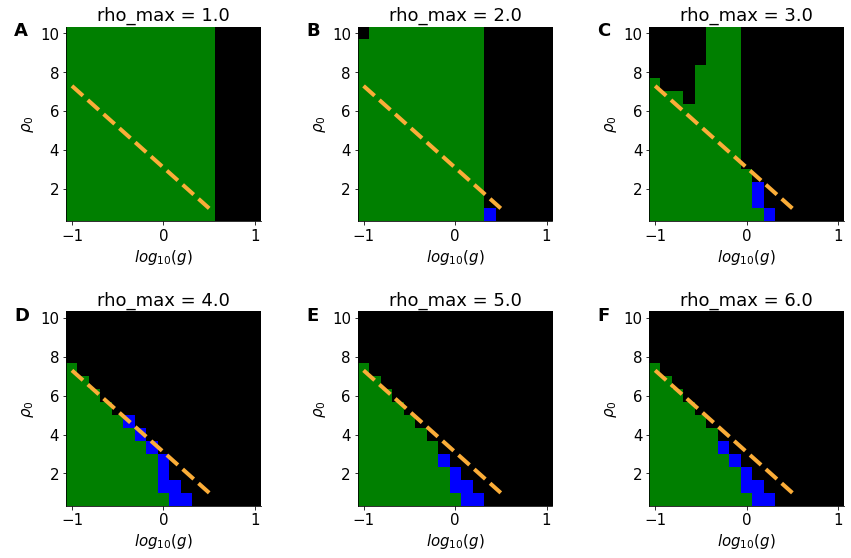

In [234]:
%%capture --no-display

plots = []

for i in range(rho_max_space.size):
    rho_max_ = rho_max_space[i]
    mask = param_space[:, 2] == rho_max_
    phase_2D = phase_behavior[mask].reshape(g_space.size, rho_0_space.size).T
    
    plot = hv.Image(
        (np.log10(g_space), rho_0_space, phase_2D)
    ).opts(
#         logx=True, 
        xlabel = r"$log_{10} (g)$",
    #     xticks = 3,
        ylabel = r"$\rho_0$",
        yticks = (2, 4, 6, 8, 10),
#         marker = "s",
#         s=180,
        cmap=["k", "b", "g"],  #[phase_behavior[mask]], 
        aspect=1,
        fontscale=1.5,
        title= f"rho_max = {rho_max_:.1f}"
    )
    
    plots.append(plot * fit_curve)

hv.Layout(plots).cols(3)

:Layout
   .Points.I   :Points   [x,y]
   .Points.II  :Points   [x,y]
   .Points.III :Points   [x,y]
   .Points.IV  :Points   [x,y]
   .Points.V   :Points   [x,y]
   .Points.VI  :Points   [x,y]
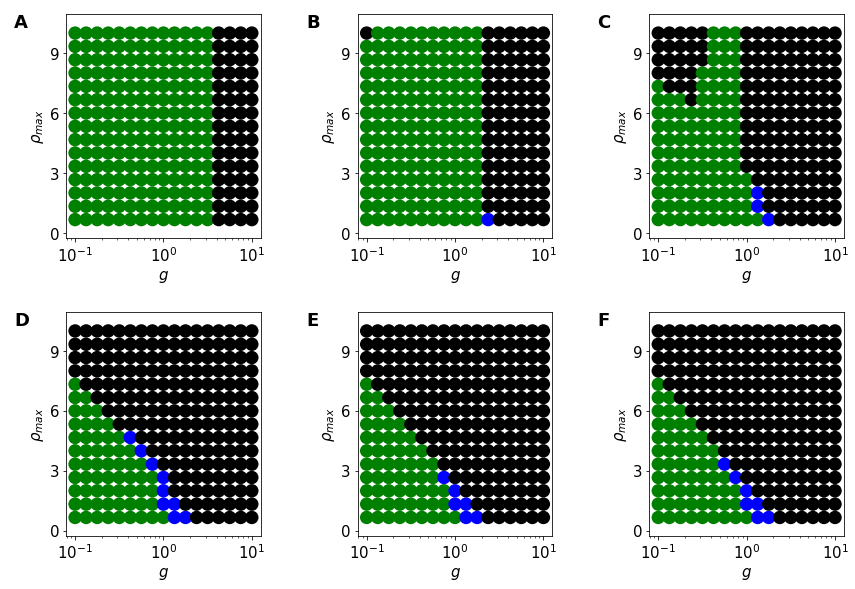

In [228]:
%%capture --no-display

plots = []

for i in range(rho_max_space.size):
    rho_max_ = rho_max_space[i]
    mask = param_space[:, 2] == rho_max_

    plot = hv.Points(
        (param_space[mask,0], param_space[mask,1])
    ).opts(
        xlabel = r"$g$",
    #     xticks = 3,
        ylabel = r"$\rho_{max}$",
        yticks = 4,
#         marker = "s",
        s=180,
        c=np.array(["k", "b", "g"])[phase_behavior[mask]], 
        logx=True, 
        aspect=2,
        fontscale=1.5,
    )
    
    plots.append(plot)

hv.Layout(plots).cols(3)

<hr>

## Scanning growth parameter space for activation behavior

__Set figure parameters__

In [315]:
# Define free parameters for parameter scan
g_space = np.logspace(-1, 1, 25)
rho_0_space = np.linspace(1, 4, 4)
rho_max_space = np.linspace(0, 10, 24)[1:]
free_params = (g_space, rho_0_space, rho_max_space)

# Generate parameter-sets
param_space = np.meshgrid(*free_params)
param_space = np.array(param_space).T.reshape(-1, len(free_params))
n_runs = param_space.shape[0]

In [323]:
# Make mutable copy of dde args
args = list(dde_args)

# Initialize results vectors
S_actnum_param = np.empty((n_runs, nt), dtype=np.float32)
S_mean_param = np.empty((n_runs, nt), dtype=np.float32)

# Make iterator
iterator = range(n_runs)
iterator = tqdm(iterator)

for i in iterator:
    
    # Get RHS function (different adjacencies)
#     rhs = (rhs_3, rhs_1, rhs_1)[i]
    rhs = rhs_1
    
    # Get parameters
    g_, rho_0_, rho_max_ = param_space[i]
    
    # Calculate density and contact length
    rho_t = lsig.logistic(t, g_, rho_0_, rho_max_)
    r_t = 1/np.sqrt(rho_t)

    args[where_g] = g_
    
    # Simulate
    S_t = lsig.integrate_DDE_varargs(
        t,
        rhs,
        var_vals=rho_t,
        where_vars=where_rho,
        dde_args=args,
        E0=S0,
        delay=delay
    )
    
    # Get activated cells
    S_act_t = S_t > k
    S_actnum_t = S_act_t.sum(axis=1)

    # Mean fluorescence
    S_mean_t = S_t.mean(axis=1)
    
    # Save results
    S_actnum_param[i] = S_actnum_t
    S_mean_param[i] = S_mean_t

100%|██████████| 2300/2300 [04:48<00:00,  7.97it/s]


In [324]:
rho_param = np.array([lsig.logistic(t, *pms) for pms in param_space])

In [326]:
# Percent of cells activated
S_prop_param = S_actnum_param / n

In [327]:
monotonicity = np.array([is_monotonic(s) for s in S_prop_param])

biphasic = np.array([is_biphasic(s, 0.2) for s in S_prop_param])

propagation_bool = np.array([is_propagated(s, 0.2) for s in S_prop_param])

# phase_behavior = (monotonicity.astype(int) + propagation_bool.astype(int)) * propagation_bool

phase_behavior = ((~biphasic).astype(int) + propagation_bool.astype(int)) * propagation_bool

:Layout
   .Overlay.I   :Overlay
      .Image.I :Image   [x,y]   (z)
      .Curve.I :Curve   [x]   (y)
   .Overlay.II  :Overlay
      .Image.I :Image   [x,y]   (z)
      .Curve.I :Curve   [x]   (y)
   .Overlay.III :Overlay
      .Image.I :Image   [x,y]   (z)
      .Curve.I :Curve   [x]   (y)
   .Overlay.IV  :Overlay
      .Image.I :Image   [x,y]   (z)
      .Curve.I :Curve   [x]   (y)
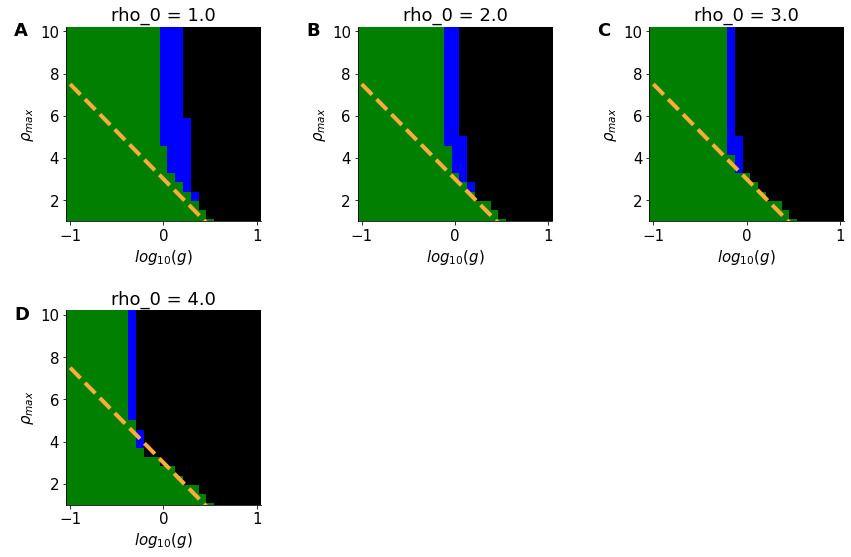

In [330]:
%%capture --no-display

plots = []

for i in range(rho_0_space.size):
    rho_0_ = rho_0_space[i]
    mask = param_space[:, 1] == rho_0_
    phase_2D = phase_behavior[mask].reshape(rho_max_space.size, g_space.size)
    
    plot = hv.Image(
        (np.log10(g_space), rho_max_space, phase_2D)
    ).opts(
#         logx=True, 
        xlabel = r"$log_{10} (g)$",
        ylim = (1, None),
    #     xticks = 3,
        ylabel = r"$\rho_{max}$",
        yticks = (2, 4, 6, 8, 10),
#         marker = "s",
#         s=180,
        cmap=["k", "b", "g"],  #[phase_behavior[mask]], 
        aspect=1,
        fontscale=1.5,
        title= f"rho_0 = {rho_0_:.1f}",
    )
    
    plots.append(plot * fit_curve)

hv.Layout(plots).cols(3)